In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.ticker as ticker
import calendar

In [244]:
df = pd.read_pickle('out/21/donations.pkl')

In [245]:
df.columns

Index([u'activity_date', u'city', u'fund', u'batch_num', u'amount_initial',
       u'amount_cleanup', u'zipcode', u'longitude', u'sales', u'county',
       u'charitable', u'amount', u'state', u'donor_id', u'timezone',
       u'latitude', u'appeal', u'activity_year', u'activity_month',
       u'activity_dow', u'activity_ym', u'activity_yq', u'activity_ymd',
       u'county_norm', u'census_region_name', u'state_name', u'is_service',
       u'channel', u'campaign_location_id', u'is_location_center',
       u'campaign_month_id', u'is_month_center'],
      dtype='object')

In [246]:
df = df[['donor_id','activity_year', 'amount', 'is_service','channel', 'city','county','state','activity_date','activity_ym','activity_month','appeal','campaign_location_id','campaign_month_id']]

## Nomenclature:
    1. Donation - is a charitable contribution
    2. Contribution - is not a charitable contribution

In [203]:
def get_data(rows):
    '''
    input: rows from dataframe for a specific donor
    output: money donated and contributed over the years
    '''
    return rows\
    .groupby(['activity_year', 'is_service'])\
    .agg({'amount': sum, 'activity_date': 'count'}).reset_index()

In [204]:
df[(df.donor_id=='_1D50SWTKX') & (df.activity_year == 2014)].reset_index()

,index,donor_id,activity_year,amount,is_service,channel,city,county,state,activity_date,activity_ym,appeal,campaign_location_id,campaign_month_id
0,177718,_1D50SWTKX,2014,3500,False,Other,Kenmore,King,WA,2014-06-20,201406,Funds_SVGives,NaN,NaN
1,177728,_1D50SWTKX,2014,50,False,Other,Kenmore,King,WA,2014-08-13,201408,Funds_Givingcampaign,NaN,NaN
2,177737,_1D50SWTKX,2014,5000,False,Matching,Kenmore,King,WA,2014-02-28,201402,Funds_Matching,NaN,NaN
3,177750,_1D50SWTKX,2014,10,False,Other,Kenmore,King,WA,2014-06-20,201406,Funds_SVGives,NaN,NaN
4,177753,_1D50SWTKX,2014,50,False,Matching,Kenmore,King,WA,2014-12-08,201412,Funds_Matching,NaN,NaN
5,177754,_1D50SWTKX,2014,425,False,Volunteer,Kenmore,King,WA,2014-09-02,201409,Funds_Volunteer_Hours,NaN,NaN
6,177759,_1D50SWTKX,2014,3510,False,Other,Kenmore,King,WA,2014-09-02,201409,Funds_SVGives,NaN,NaN


In [205]:
get_data(df[(df.donor_id=='_1D50SWTKX')])

,activity_year,is_service,amount,activity_date
0,2004,False,500,1
1,2005,False,3257,8
2,2006,False,4205,12
3,2007,False,3999,15
4,2008,False,3320,17
5,2009,False,11944,9
6,2009,True,110,2
7,2010,False,2721,7
8,2011,False,3380,10
9,2012,False,2880,8


In [206]:
donor_data = df\
.groupby('donor_id')\
.apply(get_data)\
.rename(columns={'activity_date': 'num_activities_in_year'})

donor_data.index = donor_data.index.droplevel(1)
donor_data = donor_data.reset_index()

In [207]:
year_of_donation = donor_data[(donor_data.is_service==False)]\
.groupby('donor_id')['activity_year']\
.rank(method='min')

year_of_donation.name = 'year_of_donation'

year_of_contribution = donor_data[(donor_data.is_service==True)]\
.groupby('donor_id')['activity_year']\
.rank(method='min')

year_of_contribution.name = 'year_of_contribution'

In [208]:
donor_data = pd.concat((donor_data, year_of_donation), axis=1)
donor_data = pd.concat((donor_data, year_of_contribution), axis=1)

In [209]:
# First forward fill the data and then replace with zeros if there are still any nulls lying around
donor_data.year_of_contribution = donor_data.year_of_contribution.fillna(method='ffill')
donor_data.year_of_donation = donor_data.year_of_donation.fillna(method='ffill')

donor_data.year_of_contribution = donor_data.year_of_contribution.fillna(0)
donor_data.year_of_donation = donor_data.year_of_donation.fillna(0)

In [210]:
donor_data[(donor_data.donor_id=='-0Q51CZR4Q')]

,donor_id,activity_year,is_service,amount,num_activities_in_year,year_of_donation,year_of_contribution
46,-0Q51CZR4Q,2002,True,20,1,2,1
47,-0Q51CZR4Q,2003,False,20,1,1,1
48,-0Q51CZR4Q,2004,True,48,1,1,2
49,-0Q51CZR4Q,2005,False,60,1,2,2
50,-0Q51CZR4Q,2005,True,180,2,2,3
51,-0Q51CZR4Q,2006,False,2950,8,3,3
52,-0Q51CZR4Q,2006,True,446,3,3,4
53,-0Q51CZR4Q,2007,False,2600,4,4,4
54,-0Q51CZR4Q,2007,True,225,2,4,5
55,-0Q51CZR4Q,2008,False,1073,2,5,5


### Do people tend to give more money along the years?

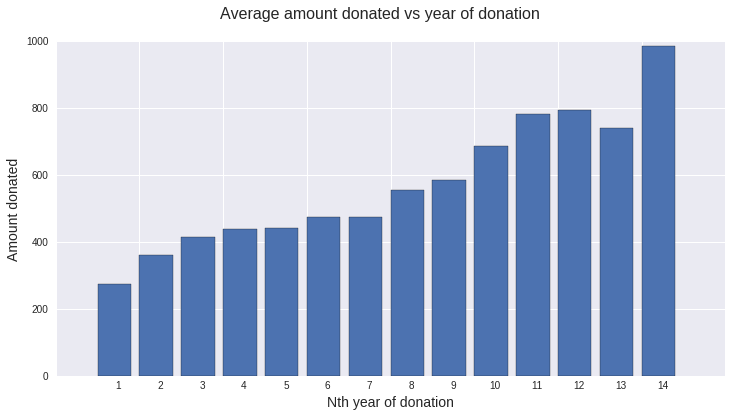

In [293]:
data = donor_data\
.groupby('year_of_donation')\
.agg({'amount': ['mean', 'std']})\
.iloc[1:-1]

data.columns = data.columns.droplevel(0)


fig, ax = plt.subplots(figsize=(12,6))
plt.bar(data.index, data['mean'])
plt.xlabel('Nth year of donation', fontsize=14)
plt.ylabel('Amount donated', fontsize=14)
ax.xaxis.set_major_formatter(ticker.NullFormatter())

ax.xaxis.set_minor_locator(ticker.FixedLocator(data.index.values+0.5))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(data.index.values.astype('int')))
_ = fig.suptitle('Average amount donated vs year of donation', fontsize=16)
plt.savefig('/home/msharath/repos/SEF/viz/Amount_Donated_In_Nth_Year.png')

In [213]:
def get_repeat_years(years):
    '''
    input: years of activity for donor
    output: list of boolean representing if the year was a repeat year donation
    '''
    #years = rows.activity_year.unique()
    repeat_years = [y for y in years.values if y-1 in years.values]
    return years.isin(repeat_years)

In [214]:
donor_data['is_repeat_year'] = donor_data[(donor_data.is_service==False)]\
    .groupby('donor_id')['activity_year']\
    .apply(get_repeat_years)

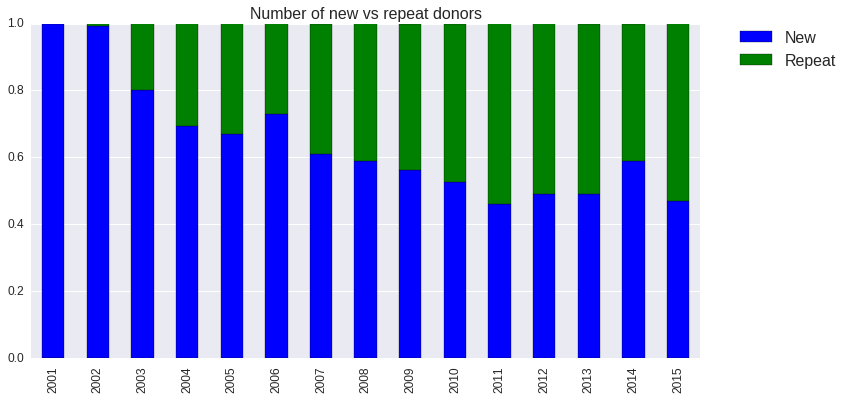

In [232]:
data = donor_data[(donor_data.is_service==False)].groupby(['activity_year', 'is_repeat_year']).donor_id.nunique().unstack().fillna(0)

data = pd.DataFrame(data.values, columns=['New','Repeat'], index=np.arange(2001, 2016))
data = data.apply(lambda x: x/x.sum(), axis=1)

plot = data.plot(kind='bar',
              stacked=True,
              fontsize=12,
              figsize=(12,6))
#plot.legend(prop={'size':16})
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':16}, borderaxespad=0.)
plot.set_title('Number of new vs repeat donors',fontsize=16)
plt.savefig('/home/msharath/repos/SEF/viz/NumberofNewVsRepeatDonors.png')

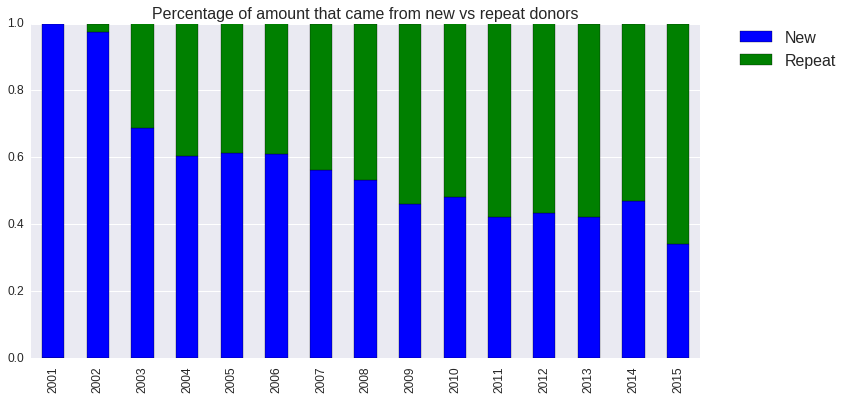

In [233]:
data = donor_data[(donor_data.is_service==False)].groupby(['activity_year', 'is_repeat_year']).amount.sum().unstack().fillna(0)
data = pd.DataFrame(data.values, columns=['New','Repeat'], index=np.arange(2001, 2016))
data = data.apply(lambda x: x/x.sum(), axis=1)

plot = data.plot(kind='bar',
              stacked=True,
              fontsize=12,
              figsize=(12,6))
#plot.legend(prop={'size':16})
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':16}, borderaxespad=0.)
plot.set_title('Percentage of amount that came from new vs repeat donors',fontsize=16)
plt.savefig('/home/msharath/repos/SEF/viz/AmountFromNewVsRepeatDonors.png')

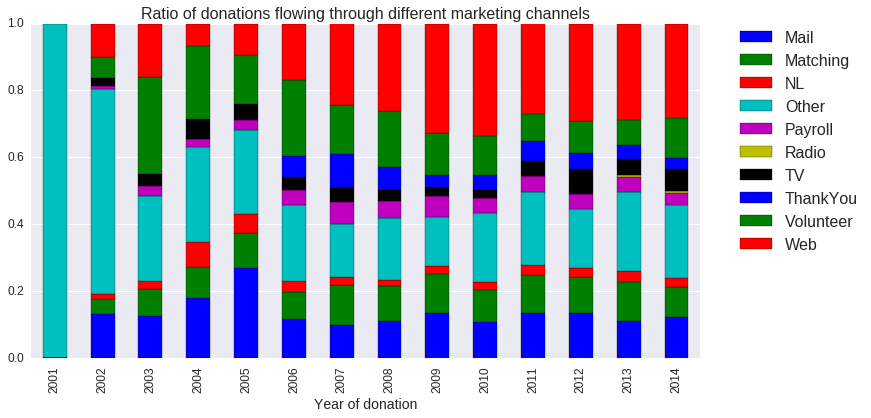

In [292]:
x = df[(df.is_service==False) & (df.activity_year!=2015)]\
    .groupby(['activity_year', 'channel']).amount.sum().to_frame().unstack().fillna(0)

y = x.apply(lambda x: x/sum(x), axis=1)
y.columns = y.columns.droplevel(0)
plot = y.plot(kind='bar',
              stacked=True,
              fontsize=12,
              figsize=(12,6))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':16}, borderaxespad=0.)
plot.set_title('Ratio of donations flowing through different marketing channels',fontsize=16)
plt.xlabel('Year of donation', fontsize=14)
plt.savefig('/home/msharath/repos/SEF/viz/DonationsFromDifferentMarketingChannels.png')

In [266]:
cumulative_years = np.cumsum(
    df[df.activity_year > 2007].groupby(['activity_year', 'activity_month'])['amount', ]\
        .sum()\
        .unstack()\
        .fillna(0)
    , axis=1, dtype='int64').T

cumulative_years.index = cumulative_years.index.droplevel(0)
cumulative_years[2015][12] = np.nan

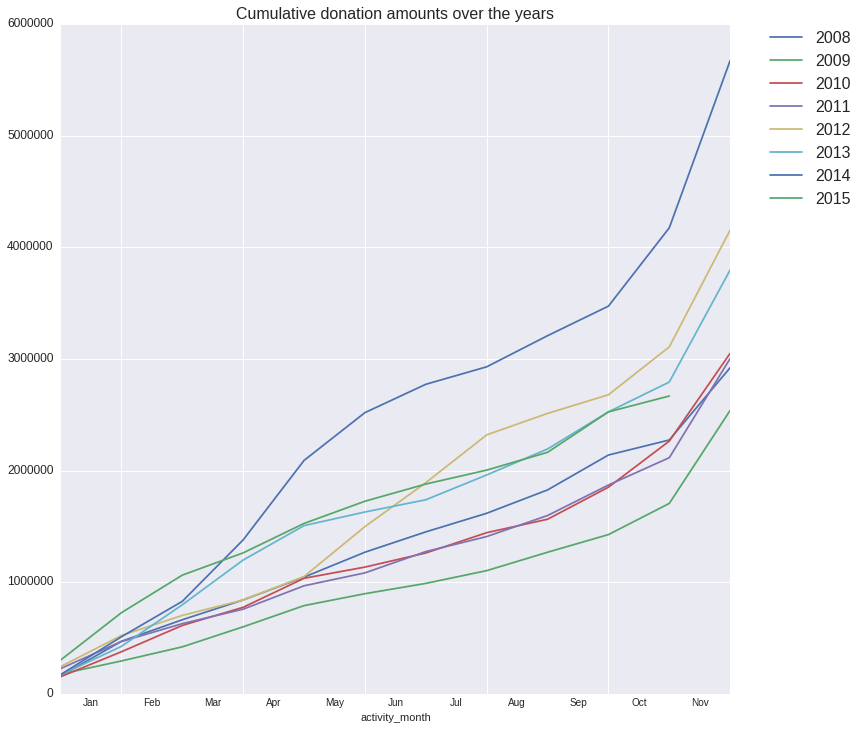

In [307]:
plot = cumulative_years.plot(kind='line',
              fontsize=12,
              figsize=(12,12))

plot.xaxis.set_major_formatter(ticker.NullFormatter())

plot.xaxis.set_minor_locator(ticker.FixedLocator(data.index.values+0.5))
plot.xaxis.set_minor_formatter(ticker.FixedFormatter(calendar.month_abbr[1:]))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':16}, borderaxespad=0.)
plot.set_title('Cumulative donation amounts over the years',fontsize=16)
plt.savefig('/home/msharath/repos/SEF/viz/CumulativeDonationsOverTheYears.png')

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name=u'activity_month')